## Loading packages and setting up Jupyter notebook

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline 
import seaborn as sns
sns.set ()

import pdb 
import missingno  # for visualizing missing data

In [2]:
# Set up pandas table display
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Set Seaborn options
sns.set_context("notebook") 

In [3]:
# mpl.rcParams['figure.figsize'] = (20.0, 10.0) 

## Inspecting data files

The data come in separate csv files that contain from a quarter up to multiple years of records. Let's inspect the individual files in the shell before importing them into pandas. 

In [4]:
!head -3 *.csv

==> LoanStats3a_securev1.csv <==
Notes offered by Prospectus (https://www.lendingclub.com/info/prospectus.action)
"id","member_id","loan_amnt","funded_amnt","funded_amnt_inv","term","int_rate","installment","grade","sub_grade","emp_title","emp_length","home_ownership","annual_inc","verification_status","issue_d","loan_status","pymnt_plan","url","desc","purpose","title","zip_code","addr_state","dti","delinq_2yrs","earliest_cr_line","fico_range_low","fico_range_high","inq_last_6mths","mths_since_last_delinq","mths_since_last_record","open_acc","pub_rec","revol_bal","revol_util","total_acc","initial_list_status","out_prncp","out_prncp_inv","total_pymnt","total_pymnt_inv","total_rec_prncp","total_rec_int","total_rec_late_fee","recoveries","collection_recovery_fee","last_pymnt_d","last_pymnt_amnt","next_pymnt_d","last_credit_pull_d","last_fico_range_high","last_fico_range_low","collections_12_mths_ex_med","mths_since_last_major_derog","policy_code","application_type","annual_inc_joint","dti

This reveals that the first line contains comments and should thus be discarded when importing the data. The column names start in the second line.

## Importing data

In [5]:
files = !ls *.csv
df_list = []
for file in files:
    df_list.append(pd.read_csv(file, header=1, low_memory=False))

all_data = pd.concat(df_list)  

## Dropping irrelevant observations

 
Before we go on to inspect the data, let us discard irrelevant rows and columns. To zoom in on only the relevant observation, let us take a look at the variable of interest, loan_status, in order to filter out cases where the outcome is ambiguous:

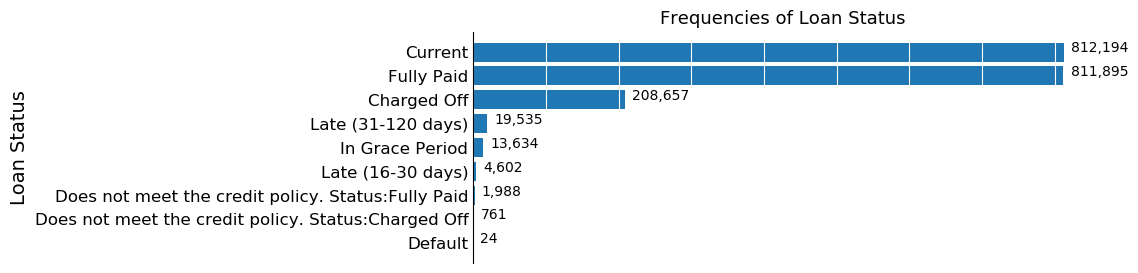

In [6]:
sns.reset_defaults()

counts = all_data.loan_status.value_counts(ascending=True)  
ind = np.arange(len(counts))  # y-axis

fig, ax = plt.subplots(figsize=(8, 3))
ax.barh(y=ind, width=counts)

ax.set_title("Frequencies of Loan Status", fontsize=13)
# ax.set_xlabel("Frequencies of Loan Status", fontsize=14)
ax.set_ylabel("Loan Status", fontsize=14)
ax.set_yticks(ind)  # Get rid of extra ticks on top and bottom
ax.set_yticklabels(counts.index)

ax.grid(axis = 'x', color ='white', linestyle='-')
sns.despine(bottom=True)
ax.tick_params(axis='both', which='both',length=0, labelsize=12, labelbottom=False)
# ax.tick_params(axis='bottom', labelsize = 0)
for y_position, count in zip(ind, counts):  # Add frequencies
    plt.annotate(format(count, ','), xy=(count+10000, y_position))

plt.show()

As the above figure shows, the vast majority of loans fall into 3 classes: Loans that are still current, Loans that were paid back completely, and loans that were written-off (i.e., loans are unlikely to be paid back). Only a small fraction of loans (in fact, only 24, too small to be visible in the graph) are categorized as defaults (meaning that we can be certain that they won't be paid back). Furthermore, there is a small number of loans for which the status variable contains the string "does not meet the credit policy" in addition to whether it is fully paid or charged-off. Unfortunately, there is no explanation anywhere what exactly this means. I will simply treat them as fully paid or charged off, and ignore the information about not meeting the credit policy, which seems to be a separate variable. However, I do not use it for prediction, because it is likely that this information only became available after the loan was issued (since presumably the loan would not have been issued if it had been known at the time that the borrower did not meet the credit policy).    

The main question we need to decide is what exactly we want to predict.  I opt for a dichotomous classification into "fully paid" versus "charged off" and "default". For simplicity sake, I will call those "good" loans and "bad" loans. Note that those two classes are imbalanced.

Loans which are late – from still being in the grace period to up to 120 days late – will be discarded, because their status is yet indeterminate.  We have enough observations already, and thus any gain in accuracy from these additional observations would most likely be more than offset by the increase in variance due to the greater measurement error, because we do not have enough information yet to accurately classify them.

For similar reasons, I will discard loans that are still current.

In [7]:
# Create target variable (good or bad loans)
all_data['good'] = np.NaN
all_data.loc[all_data.loan_status.str.contains('Fully Paid', na=False), 'good'] = 1  # "Good" loans
all_data.loc[(all_data.loan_status.str.contains('Charged Off', na=False)|(all_data.loan_status=='Default')), 'good'] = 0  # "Bad"

In [8]:
# Drop loans with indeterminate status
all_data = all_data.loc[all_data.good.notnull(),:]

## Dropping irrelevant columns

Now that we have discarded irrelevant rows, let's discard columns which are either constant or for which all observations are missing:

In [9]:
# Find columns with 0 or 1 unique values
constant_or_missing = [col for col in all_data.columns if all_data.loc[:,col].value_counts().shape[0]<=1] 
print(constant_or_missing)

# Delete those columns
all_data = all_data.drop(constant_or_missing, axis=1)

['member_id', 'pymnt_plan', 'policy_code', 'hardship_flag', 'hardship_type', 'deferral_term', 'hardship_length']


In [10]:
all_data.columns[all_data.columns.str.contains("list", case=False)]

Index(['initial_list_status'], dtype='object')

## Exploratory Data Analysis
### Missing Values
Now that we have discarded irrelevant rows and columns, let us take a closer look at the data. Firstly, let's see what percentage of each column is missing.

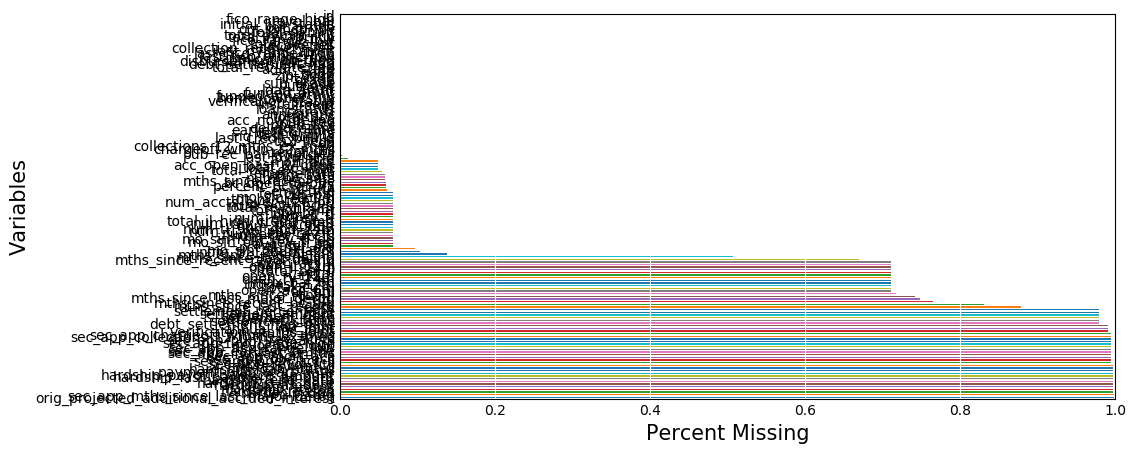

In [11]:
missing = (all_data.isnull().sum()/all_data.shape[0]).sort_values(ascending=False)
missing.plot(kind="barh", figsize=(10, 5))
plt.xlim(0, 1)
plt.xlabel('Percent Missing', fontsize=15)
plt.ylabel('Variables', fontsize=15)
plt.tick_params(labelsize=10, length=0)
plt.grid(color="white", axis='x')
# sns.despine()
plt.show()

Let us first focus on the big picture not worry about any individual variables. This reveals reveals an interesting pattern: About a third of the observations have no missing values, about a quarter of the variables has about 10% missing values, about 10% of the variables have around 70% missing values, and for about 1/3 of the variables almost all the data are missing.
The fact that there are no variables that have between 15% and 65% missing values makes it easier for us to decide at what proportion of missing values we should draw a cut-off between dropping a variable versus imputing missing values. I will choose 30% missing as the threshold, but any threshold between around 15% and around 65% would yield identical results.

Let us now take a look at how these missing values are related to when loans were issued:

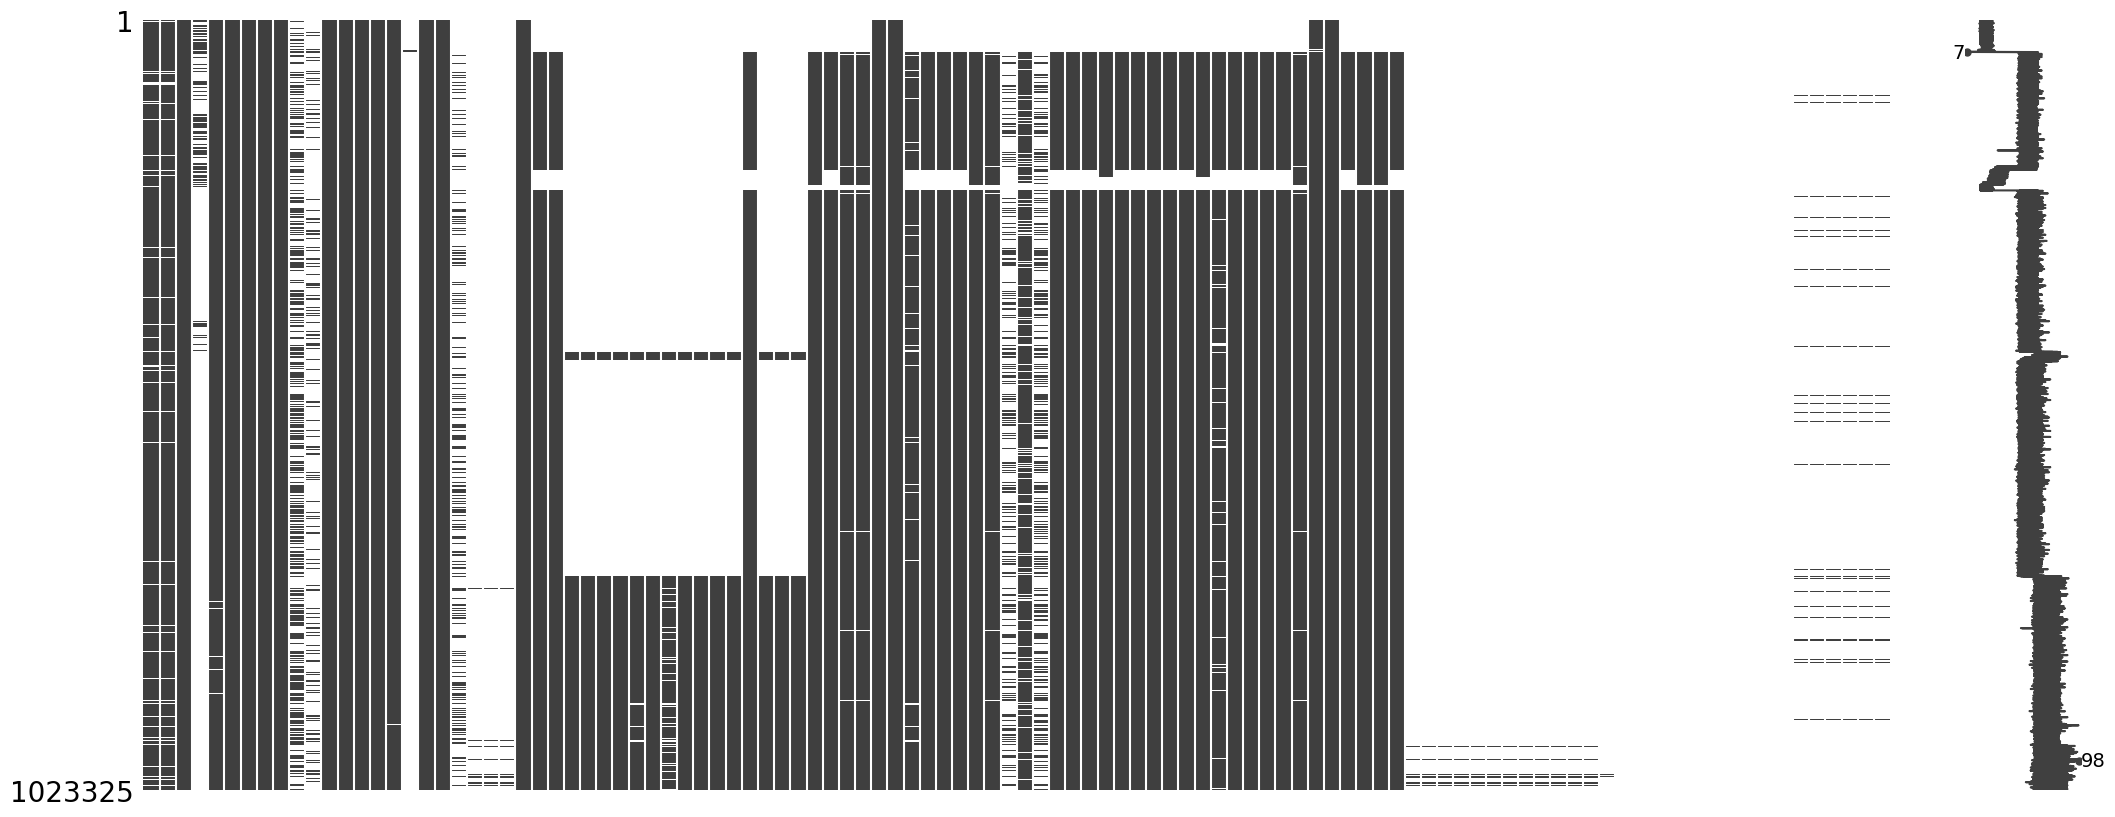

In [12]:
missingno.matrix(all_data.loc[:, all_data.isnull().any()])
plt.show();

(More detailed analysis and labeling of axes to follow.)

Before actually dropping any columns, let us first inspect which columns will get dropped:

In [15]:
# Select columns that will be dropped since they have more than 30% missing values
drop = [col for col in missing.index[missing>.3]]  

# Divide those columns into categorical and continuous to plot them separately
# (Arbitrary cutoff for continuous: greater than 10 unique values)
drop_continuous = [col for col in drop if len(all_data[col].unique())>=10] 
drop_cat = [col for col in drop if col not in drop_continuous]

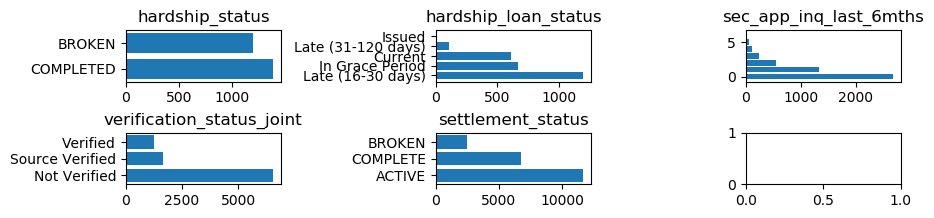

In [42]:
# Plot categorical variables to be dropped
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,2))
for subplot, col in zip(ax.ravel(), drop_cat):
    counts = all_data.loc[:,col].value_counts()
    subplot.barh(y=counts.index, width=counts)
    subplot.set_title(col)
fig.subplots_adjust(wspace=1, hspace=1)
plt.show()

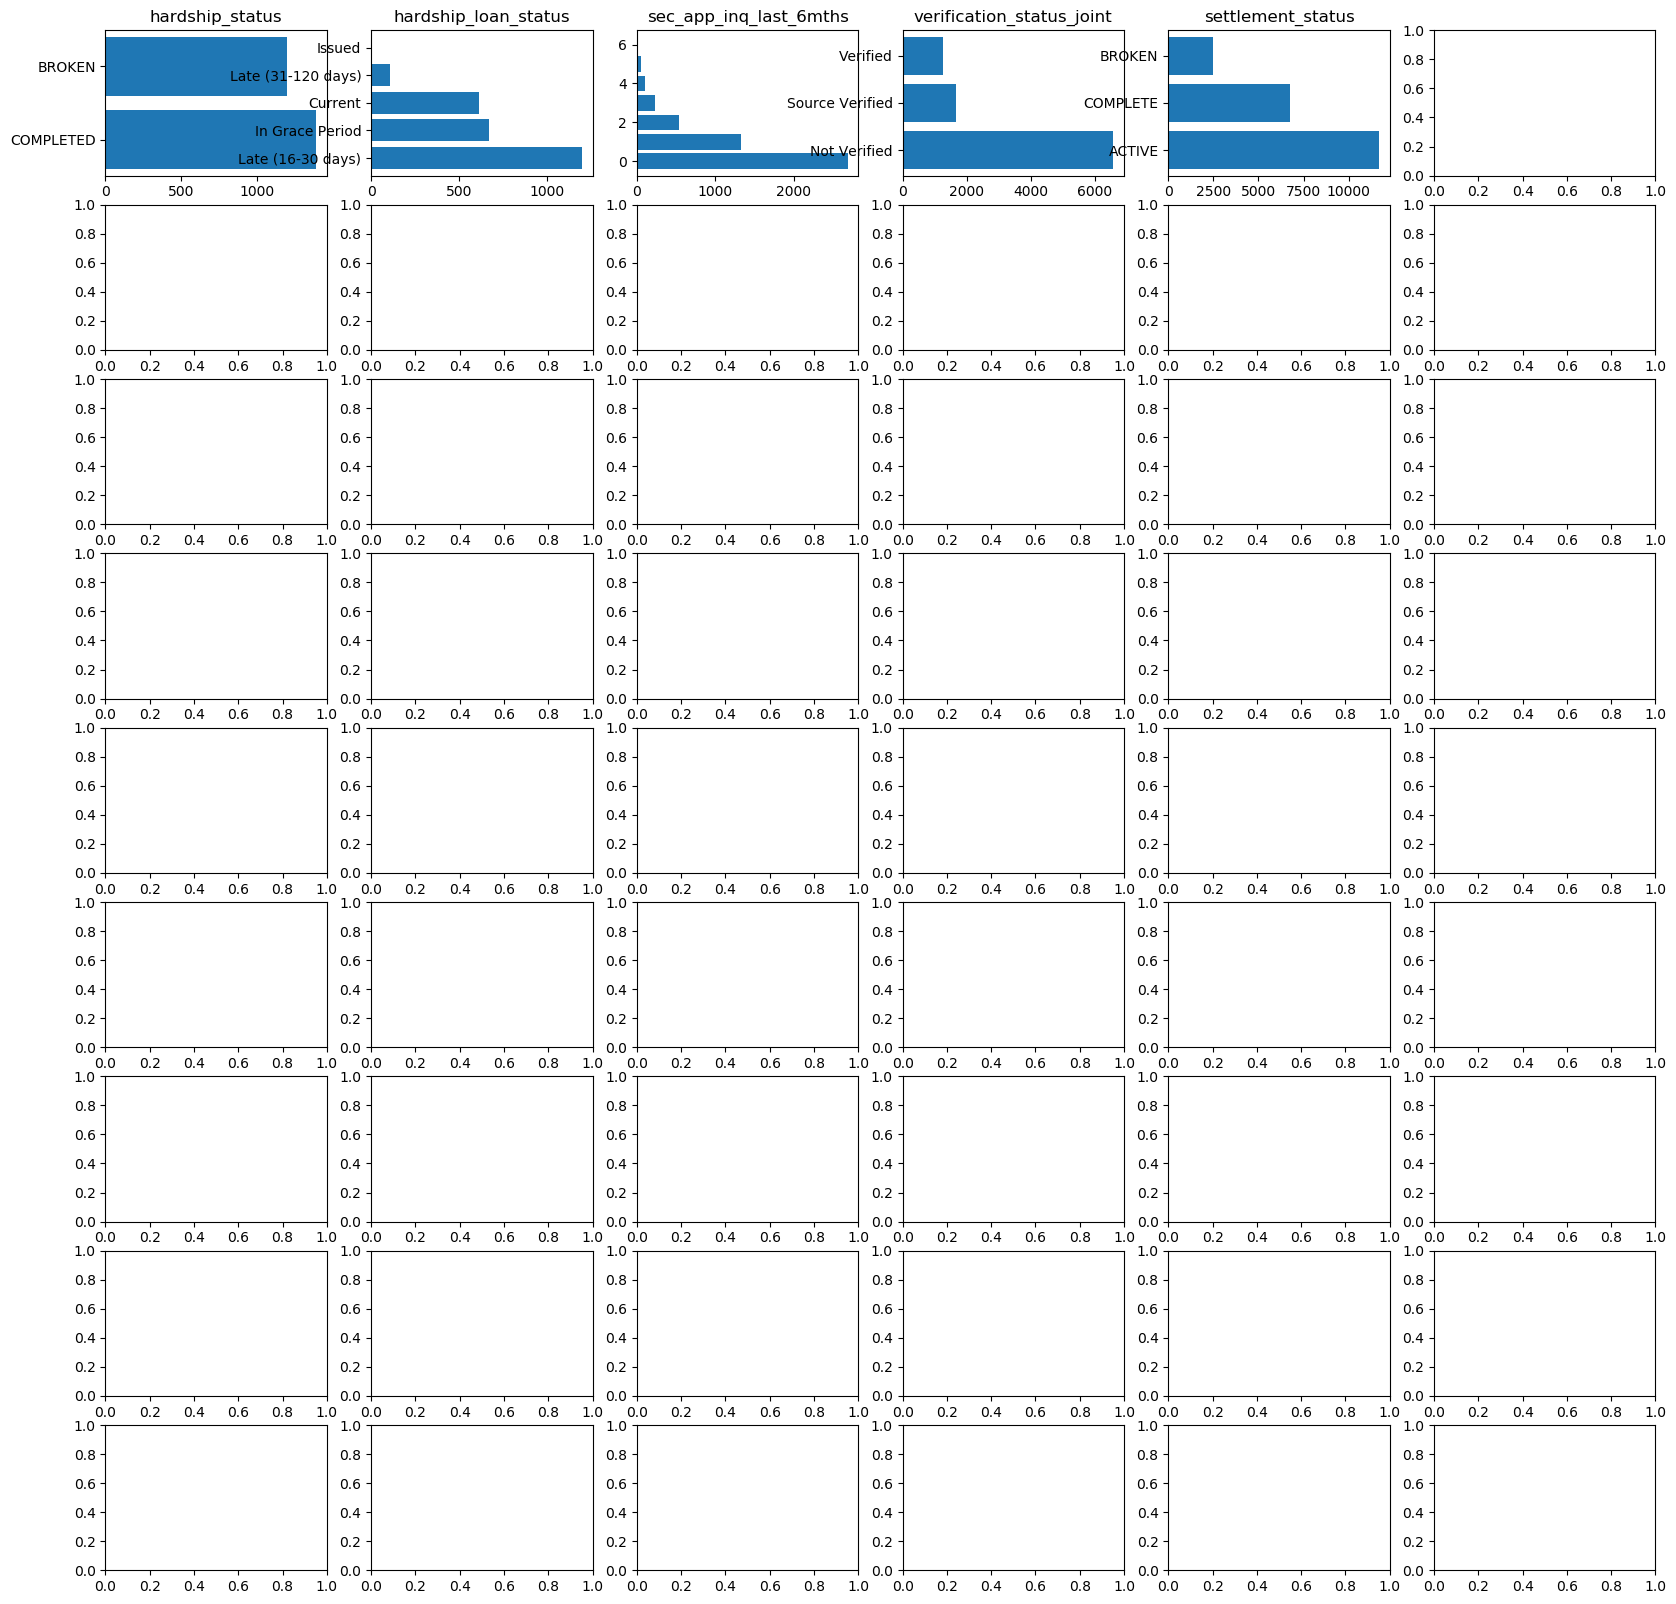

In [32]:

fig, ax = plt.subplots(nrows=9, ncols=6, figsize=(20, 20))
for subplot, col in zip(ax.ravel()[:6], drop_cat):
    counts = all_data.loc[:,col].value_counts()
    subplot.barh(y=counts.index, width=counts)
    subplot.set_title(col)
plt.show()

In [24]:
ax.ravel()[:6]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000234B1CBC978>,
      dtype=object)

In [16]:
print(drop_continuous, drop_cat)

['orig_projected_additional_accrued_interest', 'sec_app_mths_since_last_major_derog', 'hardship_dpd', 'hardship_reason', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_payoff_balance_amount', 'payment_plan_start_date', 'next_pymnt_d', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_open_acc', 'sec_app_mort_acc', 'sec_app_earliest_cr_line', 'sec_app_fico_range_low', 'revol_bal_joint', 'sec_app_fico_range_high', 'sec_app_num_rev_accts', 'sec_app_collections_12_mths_ex_med', 'sec_app_chargeoff_within_12_mths', 'annual_inc_joint', 'dti_joint', 'debt_settlement_flag_date', 'settlement_term', 'settlement_date', 'settlement_amount', 'settlement_percentage', 'desc', 'mths_since_last_record', 'mths_since_recent_bc_dlq', 'il_util', 'mths_since_last_major_derog', 'mths_since_rcnt_il', 'all_util', 'open_acc_6m', 'total_cu_tl', 'inq_last_12m', 'max_bal_bc', 'open_rv_24m', 'open_rv_12m', 'inq_fi', 'total_bal_il', 'open_il_24m', 'open_il

In [19]:
assert(len(drop) == len(drop_continuous) + len(drop_cat))